Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10956 entries, 0 to 10955
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10956 non-null  object 
 1   Ciudad        10956 non-null  object 
 2   NO (Ąg/m3)    10772 non-null  float64
 3   NO2 (Ąg/m3)   10723 non-null  float64
 4   NOX (Ąg/m3)   10731 non-null  float64
 5   PM10 (Ąg/m3)  8929 non-null   float64
 6   tavg          10950 non-null  float64
 7   tmin          10956 non-null  float64
 8   tmax          10956 non-null  float64
 9   prcp          10946 non-null  float64
 10  snow          283 non-null    float64
 11  wdir          8244 non-null   float64
 12  wspd          9522 non-null   float64
 13  wpgt          6301 non-null   float64
 14  pres          9139 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.3+ MB
None

Primeras filas del DataFrame:
         Date  Ciudad  NO (Ąg/m3)  NO2 (Ąg/m

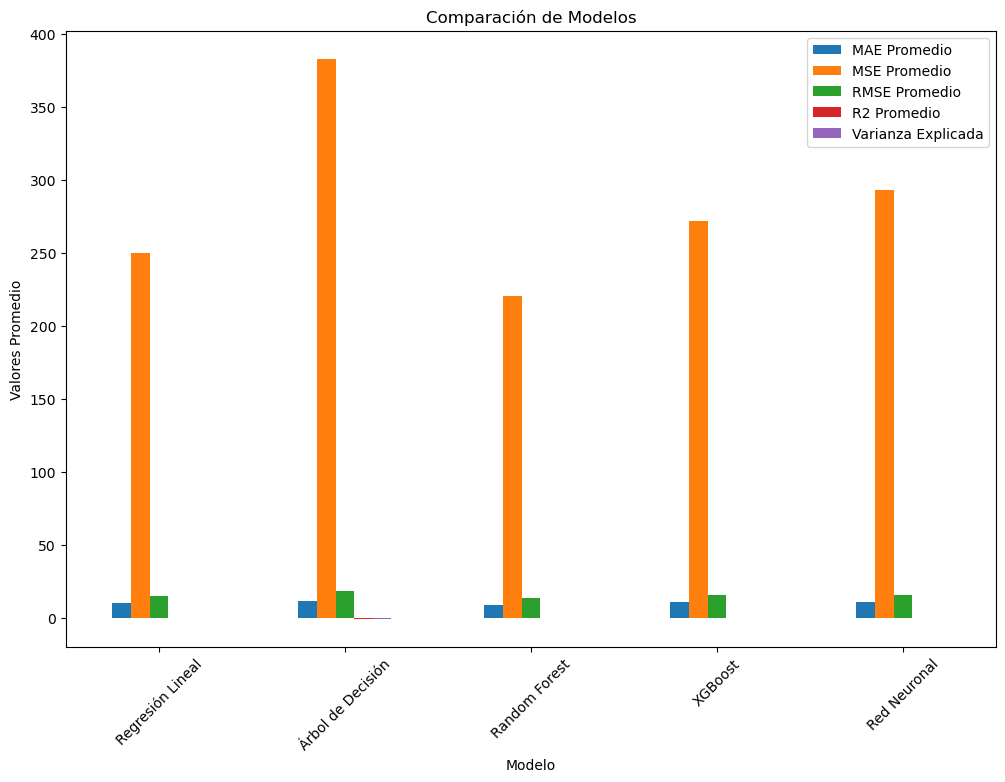

In [7]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------------
# SECCIÓN 1: Cargar y Explorar Datos
# ----------------------------------------------------
# Cargar el dataset
path = 'data/dataset.csv'
df = pd.read_csv(path)

# Explorar los datos
print("Información del DataFrame:")
print(df.info())
print("\nPrimeras filas del DataFrame:")
print(df.head())

# Convertir la columna `Date` al formato de fecha
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Resumen de valores faltantes
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje Faltante': missing_percentage
})
print("\nValores Faltantes y Porcentaje por Columna:")
print(missing_summary)

# ----------------------------------------------------
# SECCIÓN 2: Tratamiento de Datos
# ----------------------------------------------------
# Imputar valores nulos por la media mensual para cada ciudad
# Función para imputar los valores nulos por la media mensual de la ciudad
def imputar_mensual(df, ciudad, columna):
    for year in df['Date'].dt.year.unique():
        for month in range(1, 13):  # Iterar sobre los 12 meses
            # Filtrar por ciudad, año y mes directamente desde la columna 'Date'
            subset = df[(df['Ciudad'] == ciudad) & 
                        (df['Date'].dt.year == year) & 
                        (df['Date'].dt.month == month)]
            
            # Si hay datos en ese mes para ese año, usar la media de ese año
            if not subset[columna].isnull().all():
                mean_value = subset[columna].mean()
            else:
                # Si no hay datos para ese mes en ese año, calcular la media de otros años
                subset_other_years = df[(df['Ciudad'] == ciudad) & 
                                        (df['Date'].dt.month == month) & 
                                        (df['Date'].dt.year != year)]
                mean_value = subset_other_years[columna].mean() if not subset_other_years.empty else None
            
            # Si se pudo calcular una media, redondearla a un decimal y usarla para imputar
            if mean_value is not None:
                mean_value = round(mean_value, 1)
                df.loc[(df['Ciudad'] == ciudad) & 
                       (df['Date'].dt.year == year) & 
                       (df['Date'].dt.month == month) & 
                       (df[columna].isnull()), columna] = mean_value
            
    return df

# Columnas a imputar
numerical_cols = ['NO (Ąg/m3)', 'NO2 (Ąg/m3)', 'NOX (Ąg/m3)', 'PM10 (Ąg/m3)', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']

# Imputar para cada ciudad y columna
for ciudad in df['Ciudad'].unique():
    for col in numerical_cols:
        df = imputar_mensual(df, ciudad, col)

# Eliminar solo la columna 'snow' tiene demasiados valores faltantes
if 'snow' in df.columns and df['snow'].isnull().any():
    df = df.drop(columns=['snow'])

# Verificar si aún hay valores faltantes
print(df.isnull().sum())


# Codificar la columna `Ciudad` con One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=['Ciudad'], drop_first=False)

# Normalizar las variables predictoras
scaler = MinMaxScaler()
X = df_encoded[['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres']]
X_scaled = scaler.fit_transform(X)

# Definir las variables objetivo
y = df_encoded[['NO (Ąg/m3)', 'NO2 (Ąg/m3)', 'NOX (Ąg/m3)', 'PM10 (Ąg/m3)']]

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ----------------------------------------------------
# SECCIÓN 3: Entrenamiento y Optimización de Modelos
# ----------------------------------------------------
# Crear un scorer para RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Definir los hiperparámetros de los modelos
parametros = {
    'Regresión Lineal': {},  # Sin hiperparámetros clave
    'Árbol de Decisión': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 10]
    },
    'Red Neuronal': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Modelos a optimizar
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Árbol de Decisión': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Red Neuronal': MLPRegressor(max_iter=1000, random_state=42)
}

# TimeSeriesSplit para validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Optimización de hiperparámetros y almacenamiento de los mejores modelos
mejores_modelos = {}
for nombre, modelo in modelos.items():
    print(f"\nOptimizando {nombre}...")
    if parametros[nombre]:  # Si hay hiperparámetros definidos
        grid_search = GridSearchCV(estimator=modelo, param_grid=parametros[nombre], scoring=rmse_scorer, cv=tscv, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        mejores_modelos[nombre] = grid_search.best_estimator_
        print(f"Mejores parámetros para {nombre}: {grid_search.best_params_}")
    else:
        modelo.fit(X_train, y_train)
        mejores_modelos[nombre] = modelo
        print(f"{nombre} no requiere optimización de hiperparámetros.")

# ----------------------------------------------------
# SECCIÓN 4: Evaluación de Modelos
# ----------------------------------------------------
# Crear scorers personalizados para las métricas
scorers = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score),
    'Explained Variance': make_scorer(explained_variance_score)
}

# Evaluar los modelos con validación cruzada
resultados = []
for nombre, modelo in mejores_modelos.items():
    print(f"\nEvaluando {nombre}...")
    scores = cross_validate(modelo, X_train, y_train, cv=5, scoring=scorers)
    resultados.append({
        'Modelo': nombre,
        'MAE Promedio': scores['test_MAE'].mean(),
        'MSE Promedio': scores['test_MSE'].mean(),
        'RMSE Promedio': scores['test_RMSE'].mean(),
        'R2 Promedio': scores['test_R2'].mean(),
        'Varianza Explicada': scores['test_Explained Variance'].mean()
    })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
print("\nResultados:")
print(resultados_df)

# Visualizar resultados
resultados_df.set_index('Modelo', inplace=True)
resultados_df.plot(kind='bar', figsize=(12, 8), title='Comparación de Modelos')
plt.ylabel('Valores Promedio')
plt.xticks(rotation=45)
plt.show()
